In [88]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from sklearn import decomposition
from sklearn import metrics
from sklearn import preprocessing
import random

In [89]:
# METADATA 
DATASET = 0

In [90]:
def whiten_data(data):
    """
    Columns have zero mean and unit variance
    """
    return preprocessing.scale(data)

In [91]:
if DATASET == 0:
    testfile='../data/d1/data_set_ALL_AML_independent.csv'
    trainfile='../data/d1/data_set_ALL_AML_train.csv'
    patient_cancer='../data/d1/actual.csv'
    
    # load csv
    train = pd.read_csv(trainfile)
    test = pd.read_csv(testfile)
    patient_cancer = pd.read_csv(patient_cancer)
    
    # filter columns
    train_keepers = [col for col in train.columns if "call" not in col]
    test_keepers = [col for col in test.columns if "call" not in col]
    train = train[train_keepers]
    test = test[test_keepers]
    
    # remove columns with text (Gene names)
    gene_description = train['Gene Description']
    gene_accession_number = train['Gene Accession Number']
    train = train.drop(['Gene Description','Gene Accession Number'],axis=1)
    test = test.drop(['Gene Description','Gene Accession Number'],axis=1)
    
    # transpose data to have each row represent a patient
    train = train.transpose()
    test = test.transpose()
    
    # zero mean and unit variance the data
    train = whiten_data(train)
    test = whiten_data(test)
    
    # initialize the labels for the data
    # patient cancer labels to 0 (ALL) and 1 (AML)
    patient_cancer = np.array(patient_cancer)
    patient_labels = []
    for p in patient_cancer:
        if p[1] == 'ALL':
            patient_labels.append(0)
        else:
            patient_labels.append(1)
    train_labels = patient_labels[0:len(train)]
    test_labels = patient_labels[len(train):]

In [83]:
if DATASET == 1:
    all_data_path ='../data/d2/data.csv'
    all_labels_path='../data/d2/labels.csv'
    
    # load csv
    all_data = pd.read_csv(all_data_path)
    all_labels = pd.read_csv(all_labels_path)
    
    # drop first column of all_data
    all_data = all_data.as_matrix()
    all_data = all_data[:, 1:]
    
    # drop first column of labels_data
    labels_dict = {'BRCA':0, 'KIRC':1, 'PRAD':2, 'LUAD':3, 'COAD':4}
    all_labels = all_labels.as_matrix()[:,1]
    all_labels_num = []
    for label in all_labels:
        all_labels_num.append(labels_dict[label])
    all_labels_num = np.array(all_labels_num)  
    # whiten data
    all_data = whiten_data(all_data)
    
    # randomize indices and split into train and test
    indices = [i for i in range(len(all_labels_num))]
    random.shuffle(indices)
    NUM_TRAIN = int(0.8*len(indices))
    train = all_data[indices[:NUM_TRAIN],:]
    train_labels = all_labels_num[indices[:NUM_TRAIN]]
    test = all_data[indices[NUM_TRAIN:],:]
    test_labels = all_labels_num[indices[NUM_TRAIN:]]
    

In [84]:
# Distribution of class labels
print len([a for a in all_labels_num if a == 0])
print len([a for a in all_labels_num if a == 1])
print len([a for a in all_labels_num if a == 2])
print len([a for a in all_labels_num if a == 3])
print len([a for a in all_labels_num if a == 4])

300
146
136
141
78


### PCA Analysis

In [66]:
from sklearn.decomposition import PCA
NUM_COMPONENTS = 2
def _pca(data, num_comp):
    pca = PCA(n_components=num_comp)
    pca.fit(data)
    data_pca = pca.transform(data)
    return data_pca

In [67]:
# train
train_pca = _pca(train, NUM_COMPONENTS)
test_pca = _pca(test, NUM_COMPONENTS)

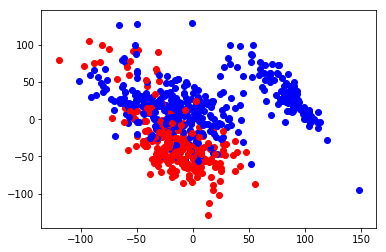

In [69]:
train_pca.shape
for i,p in enumerate(train_pca):
    if train_labels[i] == 0:
        plt.scatter(train_pca[i,0], train_pca[i,1], color='r', label='ALL')
    else:
        plt.scatter(train_pca[i,0], train_pca[i,1], color = 'b', label='AML')

plt.show()

### Naive Bayes Classifier

In [70]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
def _naive_bayes(ftrain, ftest):
    clf = GaussianNB()
    clf.fit(ftrain, train_labels)
    predicted = clf.predict(ftest)
    acc = accuracy_score(test_labels, predicted)
#     print(metrics.classification_report(test_labels, predicted))
    return acc

#### Accuracy VS Number of Components for Naive Bayes

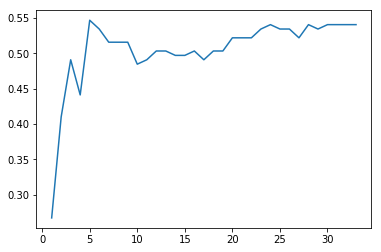

In [71]:
max_components = 33
accuracies = []
for i in range(max_components):
    nc = i + 1
    nc_pca_train = _pca(train, nc)
    nc_pca_test = _pca(test, nc)
    accuracies.append(_naive_bayes(nc_pca_train, nc_pca_test))
plt.plot([i+1 for i in range(max_components)], accuracies)
plt.show()
    

### SVM Classifier

In [72]:
from sklearn import svm
clf = svm.SVC()
# Try training on entire feature set
clf.fit(train, train_labels)
predicted = clf.predict(test)
print(metrics.classification_report(test_labels, predicted))

def _svm(ftrain, ftest):
    clf = svm.SVC()
    clf.fit(ftrain, train_labels)
    predicted = clf.predict(ftest)
    acc = accuracy_score(test_labels, predicted)
    return acc

             precision    recall  f1-score   support

          0       0.98      1.00      0.99        56
          1       1.00      0.96      0.98        28
          2       1.00      1.00      1.00        29
          3       1.00      1.00      1.00        31
          4       1.00      1.00      1.00        17

avg / total       0.99      0.99      0.99       161



#### Accuracy VS Number of Components for SVM

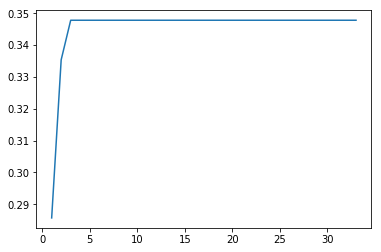

In [73]:
max_components = 33
accuracies = []
for i in range(max_components):
    nc = i + 1
    nc_pca_train = _pca(train, nc)
    nc_pca_test = _pca(test, nc)
    accuracies.append(_svm(nc_pca_train, nc_pca_test))
plt.plot([i+1 for i in range(max_components)], accuracies)
plt.show()


## F Score Feature Selection

In [74]:
import fscore_select_k_2 as fsk

In [75]:
h, w = train.shape
fsk_mat = np.zeros((h, w+1))
fsk_mat[:,:w] = train
fsk_mat[:, w] = train_labels
k = 35

In [76]:
fsk_op = fsk.GeneSelection2(fsk_mat)
ordered_fscore_columns = fsk_op.select_k(k) # sorted list of f scores with the column they correspond to

/Users/ajayshekar/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2968: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


KeyboardInterrupt: 

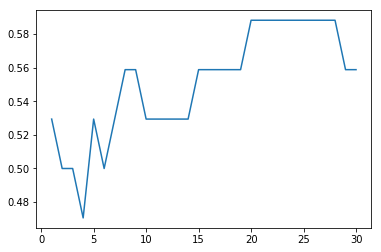

In [34]:
# Visualize for classifier X, how does accuracy vary with number of features selected (1 to k)
num_components = 30
fs_nb_accuracies = []
for i in range(num_components):
    nc = i + 1
    fs_train = train[:, ordered_fscore_columns[:nc]]
    fs_test = test[:, ordered_fscore_columns[:nc]]
    fs_nb_accuracies.append(_naive_bayes(fs_train, fs_test))
plt.plot([i+1 for i in range(num_components)], fs_nb_accuracies)
plt.show()

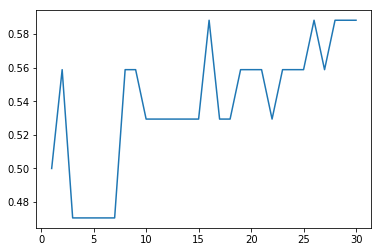

In [35]:
num_components = 30
fs_svm_accuracies = []
for i in range(num_components):
    nc = i + 1
    fs_train = train[:, ordered_fscore_columns[:nc]]
    fs_test = test[:, ordered_fscore_columns[:nc]]
    fs_svm_accuracies.append(_svm(fs_train, fs_test))
plt.plot([i+1 for i in range(num_components)], fs_svm_accuracies)
plt.show()

## DPP Feature Selection

In [21]:
import sys
sys.path.append("./dpp")
import dpp

In [22]:
# sigmas = [0.0001, 0.1, 1, 2, 10]
sigmas = [1]
k = 1
train_cov = np.abs(np.cov(train.T))
gene_indices = [i for i in range(train.shape[1])]

### Train different classifiers on dpp features.

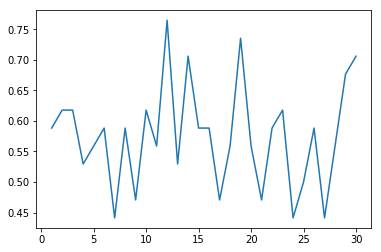

In [23]:
# Naive Bayes
dpp_nb_accuracies = []
num_components = 30
for i in range(num_components):
    nc = i+1
    selected_features = dpp.sample_k(gene_indices, train_cov, nc, max_nb_iterations=20000)  
    dpp_train = train[:, selected_features]
    dpp_test = test[:, selected_features]
    dpp_nb_accuracies.append(_naive_bayes(dpp_train, dpp_test))
plt.plot([i+1 for i in range(num_components)], dpp_nb_accuracies)
plt.show()


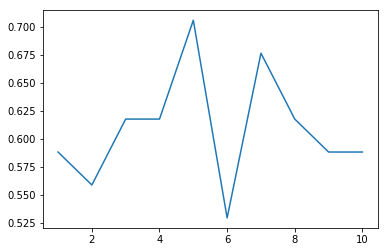

In [111]:
# SVM
dpp_svm_accuracies = []
num_components = 10
for i in range(num_components):
    nc = i+1
    selected_features = dpp.sample_k(gene_indices, train_cov, nc, max_nb_iterations=20000)  
    dpp_train = train[:, selected_features]
    dpp_test = test[:, selected_features]
    dpp_svm_accuracies.append(_svm(dpp_train, dpp_test))
plt.plot([i+1 for i in range(num_components)], dpp_svm_accuracies)
plt.show()

## DPP + FS 50-50

In [117]:
#this method takes selects k/2 genes from the f-score and k/2 from the DPP
def fs_dpp_select_k(k, train, train_cov, fsk_mat):
    fsk_obj = fsk.GeneSelection2(fsk_mat)
    f_score_genes = fsk_obj.select_k(k)
    f_score_genes = set(f_score_genes)
    gene_indices = [i for i in range(train.shape[1])]

    dpp_k_features = dpp.sample_k(gene_indices, train_cov, k, max_nb_iterations=20000)


    for gene in dpp_k_features:
            #if we still don't have k genes, then add genes into
            if gene not in f_score_genes:
                f_score_genes.add(gene)

            #we have reached k genes thus we can stop
            if len(f_score_genes) == k:
                break


    return list(f_score_genes)

# Putting Results Together:

In [98]:
NUM_FEATURES = [5, 10, 15, 20, 25, 30]

## Naive Bayes - Multiple Feature Selection Methods

#### 1) PCA

In [103]:
nb_pca_acc = []
for nf in NUM_FEATURES:
    pca_train = _pca(train, nf)
    pca_test = _pca(test, nf)
    nb_pca_acc.append(_naive_bayes(pca_train, pca_test))

#### 2) F Score

In [105]:
h, w = train.shape
fsk_mat = np.zeros((h, w+1))
fsk_mat[:,:w] = train
fsk_mat[:, w] = train_labels
k = 35
fsk_op = fsk.GeneSelection2(fsk_mat)
ordered_fscore_columns = fsk_op.select_k(k) # sorted list of f scores with the column they correspond to

In [106]:
nb_fs_acc = []
for nf in NUM_FEATURES:
    fs_train = train[:, ordered_fscore_columns[:nf]]
    fs_test = test[:, ordered_fscore_columns[:nf]]
    nb_fs_acc.append(_naive_bayes(fs_train, fs_test))

#### 3) DPP

In [108]:
train_cov = np.abs(np.cov(train.T))
gene_indices = [i for i in range(train.shape[1])]

In [109]:
nb_dpp_acc = []
for nf in NUM_FEATURES:
    selected_features = dpp.sample_k(gene_indices, train_cov, nf, max_nb_iterations=20000)  
    dpp_train = train[:, selected_features]
    dpp_test = test[:, selected_features]
    nb_dpp_acc.append(_naive_bayes(dpp_train, dpp_test))

#### 4) DPP + F Score - 50-50

In [118]:
nb_dpp_fs_acc = []
for nf in NUM_FEATURES:
    selected_features = fs_dpp_select_k(nf, train, train_cov, fsk_mat) # uses variables from previous cells
    print selected_features
    dpp_fs_train = train[:, selected_features]
    dpp_fs_test = test[:, selected_features]
    nb_dpp_fs_acc.append(_naive_bayes(dpp_fs_train, dpp_fs_test))

[2019, 2918, 1961, 5038, 1744, 5908, 4846, 3319, 1144, 5659]
[4129, 2019, 3268, 4582, 3846, 4137, 1833, 460, 4846, 2287, 1744, 3602, 4195, 2548, 5038, 3319, 1336, 2810, 3866, 6431]
[3846, 912, 3474, 1557, 4249, 6150, 1833, 4522, 5038, 6200, 3257, 58, 831, 2241, 968, 1993, 460, 1744, 4195, 3157, 4568, 1881, 1248, 2019, 4846, 2287, 3319, 3194, 5116, 4861]
[3846, 4360, 777, 6538, 3738, 4271, 3752, 1833, 5038, 1583, 6199, 6200, 3257, 957, 2110, 3647, 2241, 1123, 1990, 2120, 460, 4942, 1744, 6737, 4195, 2134, 6073, 1881, 7003, 1248, 2019, 6372, 3432, 2409, 4846, 2287, 4723, 6644, 3319, 763]
[4738, 7045, 3846, 7, 1673, 6538, 3555, 2192, 6802, 3859, 4889, 1054, 6952, 1833, 6827, 5038, 2868, 6199, 6200, 3257, 5820, 2110, 2241, 3394, 2758, 2120, 7114, 460, 5197, 1744, 4195, 4439, 1881, 4442, 5982, 1248, 2401, 2019, 6372, 1387, 1042, 4846, 2287, 2497, 2932, 6324, 3319, 2042, 6011, 6653]
[130, 3846, 1673, 6538, 3083, 1581, 5358, 6802, 3604, 6805, 6745, 2656, 5917, 1828, 902, 4390, 2884, 1833, 145

In [119]:
nb_dpp_fs_acc

[0.55882352941176472,
 0.61764705882352944,
 0.61764705882352944,
 0.55882352941176472,
 0.55882352941176472,
 0.55882352941176472]

#### Visualize Results